In [1]:
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
import time
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

stopWords = set(stopwords.words('english'))

In [2]:
def get_jobs(keyword, num_jobs, verbose):
    
    '''Gathers jobs as a dataframe, scraped from Glassdoor'''
    
    #Initializing the webdriver
    options = webdriver.ChromeOptions()
    
    #Uncomment the line below if you'd like to scrape without a new Chrome window every time.
    #options.add_argument('headless')
    
    #Change the path to where chromedriver is in your home folder.
    driver = webdriver.Chrome(executable_path="path_to_your_chromedriver", options=options)
    driver.set_window_size(1120, 1000)

    url = 'https://www.glassdoor.com/Job/jobs.htm?sc.keyword="' + keyword + '"&locT=C&locId=1150505&locKeyword=Los%20Angeles,%20CA&jobType=all&fromAge=-1&minSalary=0&includeNoSalaryJobs=true&radius=100&cityId=-1&minRating=0.0&industryId=-1&sgocId=-1&seniorityType=all&companyId=-1&employerSizes=0&applicationType=0&remoteWorkType=0'
    driver.get(url)
    global jobs
    jobs = []

    # Let the page load. Change this number based on your internet speed.
    # Or, wait until the webpage is loaded, instead of hardcoding it.
    time.sleep(5)

    # Click on the first job & Test for the "Sign Up" prompt and get rid of it.
    driver.find_element_by_xpath("//*[@id='MainCol']/div[1]/ul/li[1]").click()

    time.sleep(1)
    
    # Clicking on the Close X button to close the "Sign Up" prompt.
    driver.find_element_by_xpath('//*[@id="JAModal"]/div/div[2]/span').click()  
    
    time.sleep(5)
    
    # Clicking on the "Search" button to search for the job postings based on keywords entered. 
    driver.find_element_by_xpath('//*[@id="scBar"]/div/button/span').click()
    time.sleep(10)

    while len(jobs) < num_jobs:
        
        # Going through each job in this page
        job_buttons = driver.find_elements_by_xpath("//*[@id='MainCol']/div[1]/ul/li")
        
        for job_button in job_buttons:  
            print("Progress: {}".format("" + str(len(jobs)) + "/" + str(num_jobs)))
            if len(jobs) >= num_jobs:
                # When the number of jobs collected has reached the number we set. 
                break
            job_button.click()  
            time.sleep(5)
            collected_successfully = False
            
            while not collected_successfully:
                try:
                    time.sleep(5)
                    company_name = driver.find_element_by_xpath('//*[@id="JDCol"]/div/article/div/div[1]/div/div/div[1]/div[3]/div[1]/div[1]').text
                    location = driver.find_element_by_xpath('//*[@id="JDCol"]/div/article/div/div[1]/div/div/div[1]/div[3]/div[1]/div[3]').text
                    job_title = driver.find_element_by_xpath('//*[@id="JDCol"]/div/article/div/div[1]/div/div/div[1]/div[3]/div[1]/div[2]').text
                    job_description = driver.find_element_by_xpath('//div[@class="jobDescriptionContent desc"]').text
                    collected_successfully = True
                except:
                    time.sleep(5)
                    collected_successfully = True
            try:
                salary_estimate = driver.find_element_by_xpath('//*[@id="JDCol"]/div/article/div/div[1]/div/div/div[1]/div[3]/div[1]/div[4]/span').text
            except NoSuchElementException:
                salary_estimate = -1 # You need to set a "not found value. It's important."
            
            try:
                rating = driver.find_element_by_xpath('//*[@id="JDCol"]/div/article/div/div[1]/div/div/div[1]/div[3]/div[1]/div[1]/span').text
            except NoSuchElementException:
                rating = -1 # You need to set a "not found value. It's important."

            #Printing for debugging
            if verbose:
                print("Job Title: {}".format(job_title))
                print("Salary Estimate: {}".format(salary_estimate))
                print("Job Description: {}".format(job_description))
                print("Rating: {}".format(rating))
                print("Company Name: {}".format(company_name))
                print("Location: {}".format(location))

            #Going to the Company tab...
            #clicking on this:
            time.sleep(5)

            try:
                driver.find_element_by_xpath('//div[@data-item="tab" and @data-tab-type="overview"]').click()
                time.sleep(5)

                try:
                    size = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[1]/span[2]').text
                except NoSuchElementException:
                    size = -1

                try:
                    founded = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[2]/span[2]').text
                except NoSuchElementException:
                    founded = -1

                try:
                    type_of_ownership = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[3]/span[2]').text
                except NoSuchElementException:
                    type_of_ownership = -1

                try:
                    industry = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[4]/span[2]').text
                except NoSuchElementException:
                    industry = -1

                try:
                    sector = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[5]/span[2]').text
                except NoSuchElementException:
                    sector = -1

                try:
                    revenue = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[6]/span[2]').text
                except NoSuchElementException:
                    revenue = -1

            except NoSuchElementException:  # Rarely, some job postings do not have the "Company" tab.
                
                size = -1
                founded = -1
                type_of_ownership = -1
                industry = -1
                sector = -1
                revenue = -1
                             
            if verbose:
                
                print("Size: {}".format(size))
                print("Founded: {}".format(founded))
                print("Type of Ownership: {}".format(type_of_ownership))
                print("Industry: {}".format(industry))
                print("Sector: {}".format(sector))
                print("Revenue: {}".format(revenue))
                
                print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            jobs.append({
            "Job Title" : job_title,
            "Salary Estimate" : salary_estimate,
            "Job Description" : job_description,
            "Rating" : rating,
            "Company Name" : company_name,
            "Location" : location,
            "Size" : size,
            "Founded" : founded,
            "Type of ownership" : type_of_ownership,
            "Industry" : industry,
            "Sector" : sector,
            "Revenue" : revenue
            })

        #Clicking on the "next page" button
        try:
            driver.find_element_by_xpath('//*[@id="FooterPageNav"]/div/ul/li[7]/a/span').click()
            time.sleep(10)
        except NoSuchElementException:
            print("Scraping terminated before reaching target number of jobs. Needed {}, got {}.".format(num_jobs, len(jobs)))
            break
            
    #This line converts the dictionary object into a pandas DataFrame.
    return pd.DataFrame(jobs)  

In [3]:
#This line will open a new chrome window and start the scraping.
# data = get_jobs("Data Scientist", 10, False)
# data = pd.DataFrame(jobs)
# data.head()

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable
1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD)
2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD)
3,Data Scientist,$137K-$171K (Glassdoor est.),JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON\n3.5,"Newton, MA",501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD)
4,Data Scientist,$137K-$171K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable


In [6]:
# Filter Glassdoor est. data only 
df['glassdoor est'] = df['Salary Estimate'].apply(lambda x: 1 if 'glassdoor est.' in x.lower() else 0)
df = df[df['glassdoor est'] == 1]

In [7]:
# Calculate average salary and drop non-useful columns
salary = df['Salary Estimate'].apply(lambda x: x.split('(')[0])
minus_Kd = salary.apply(lambda x: x.replace('K','').replace('$',''))

df['min_salary'] = minus_Kd.apply(lambda x: int(x.split('-')[0]))
df['max_salary'] = minus_Kd.apply(lambda x: int(x.split('-')[1]))
df['Salary'] = (df.min_salary+df.max_salary)*1000/2
df = df.drop(['Salary Estimate', 'glassdoor est', 'min_salary', 'max_salary'],1)

In [8]:
# Company name text only
df['Company Name'] = df.apply(lambda x: x['Company Name'] if x['Rating'] <0 else x['Company Name'].split('\n')[0], axis = 1)

In [9]:
# Create new features such as city & state 
df['City'] = df['Location'].apply(lambda x: x.split(',')[0] if ',' in x.lower() else x)
df['State'] = df['Location'].apply(lambda x: x.split(',')[1] if ',' in x.lower() else x) 
df = df.drop(['Location'],1)
df.head()

,Job Title,Job Description,Rating,Company Name,Size,Founded,Type of ownership,Industry,Sector,Revenue,Salary,City,State
0,Sr Data Scientist,Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,154000.0,New York,NY
1,Data Scientist,"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),154000.0,Chantilly,VA
2,Data Scientist,Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),154000.0,Boston,MA
3,Data Scientist,JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),154000.0,Newton,MA
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,154000.0,New York,NY


In [10]:
# Calculate the age of company 
df['Founded'] = df['Founded'].apply(lambda x: np.nan if x in ['Company - Private', '-1', 'Company - Public', 'Unknown', 'Contract', 'Nonprofit Organization', 'Self-employed'] else x)
df['Age'] = df['Founded'].apply(lambda x: x if x is np.nan else 2021 - int(x))
df = df.drop(['Founded'],1)

In [11]:
# Python
df['Python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
 
# R studio 
df['R'] = df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)

# SQL 
df['SQL'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)

# AWS 
df['AWS'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)

# Excel
df['Excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

# Google Cloud
df['GCP'] = df['Job Description'].apply(lambda x: 1 if 'google cloud' in x.lower() or 'gcp' in x.lower() else 0)

# Microsoft Azure
df['Azure'] = df['Job Description'].apply(lambda x: 1 if 'microsoft azure' in x.lower() or 'azure' in x.lower() else 0)

# Spark
df['Spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)

# PyTorch
df['PyTorch'] = df['Job Description'].apply(lambda x: 1 if 'pytorch' in x.lower() else 0)

# TensorFlow
df['TensorFlow'] = df['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() else 0)

# Tableau
df['Tableau'] = df['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)

# Keras
df['Keras'] = df['Job Description'].apply(lambda x: 1 if 'keras' in x.lower() else 0)

In [12]:
# Convert size to lower case
df['Size'] = df['Size'].str.lower()
df.head()

,Job Title,Job Description,Rating,Company Name,Size,Type of ownership,Industry,Sector,Revenue,Salary,...,SQL,AWS,Excel,GCP,Azure,Spark,PyTorch,TensorFlow,Tableau,Keras
0,Sr Data Scientist,Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,1001 to 5000 employees,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,154000.0,...,0,1,0,0,1,0,0,0,0,0
1,Data Scientist,"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,5001 to 10000 employees,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),154000.0,...,1,0,0,0,0,0,0,0,0,0
2,Data Scientist,Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,1001 to 5000 employees,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),154000.0,...,0,1,1,0,0,0,0,0,0,0
3,Data Scientist,JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,501 to 1000 employees,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),154000.0,...,1,1,1,0,0,0,1,1,0,0
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,154000.0,...,1,0,1,0,0,0,0,0,0,0


In [13]:
df.columns

Index(['Job Title', 'Job Description', 'Rating', 'Company Name', 'Size',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Salary', 'City',
       'State', 'Age', 'Python', 'R', 'SQL', 'AWS', 'Excel', 'GCP', 'Azure',
       'Spark', 'PyTorch', 'TensorFlow', 'Tableau', 'Keras'],
      dtype='object')

In [14]:
# Creating a function to encapsulate preprocessing job description & job title
def processing(df):
    # Lowering and removing punctuation
    df['Job Title'] = df['Job Title'].apply(lambda x: ' '.join(x.split()))
    df['Job Title'] = df['Job Title'].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))
    df['Job Description'] = df['Job Description'].apply(lambda x: ' '.join(x.split()))
    df['Job Description'] = df['Job Description'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    df['Job Description'] = df['Job Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopWords]))                                            
    return(df)

df = processing(df)

In [15]:
# Classifying job titles into each category
def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'data analyst'
    elif 'machine learning' in title.lower():
        return 'machine learning engineer'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'data science related jobs'

# Classifying job levels into each category
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'vp' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower()or 'experienced' in title.lower() or 'iii' in title.lower() or 'research' in title.lower() or 'manager' in title.lower():
        return 'Senior'
    elif 'intermediate' in title.lower() or 'staff' in title.lower() or 'ii' in title.lower():
        return 'Mid'
    elif 'jr' in title.lower() or 'junior' in title.lower() or 'intern' in title.lower() or 'student' in title.lower()or 'associate' in title.lower():
        return 'Junior'
    else:
        return 'Not Specified'

In [16]:
# Process data based on above defined functions 
df['Job'] = df['Job Title'].apply(title_simplifier)
df['Seniority'] = df['Job Title'].apply(seniority)

In [17]:
df['Job'].value_counts()

data scientist               1087
data science related jobs     151
data analyst                  123
data engineer                 117
machine learning engineer      46
manager                        19
director                       10
Name: Job, dtype: int64

In [18]:
df['Seniority'].value_counts()

Not Specified    1112
Senior            362
Mid                40
Junior             39
Name: Seniority, dtype: int64

Text(0.5, 1.0, 'Salary Distribution')

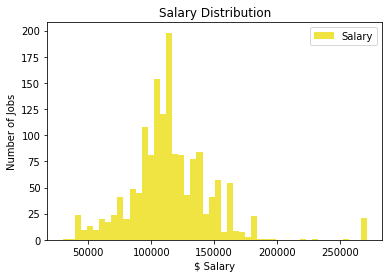

In [19]:
x = list(df.Salary)

colors = ['#F0E442']
names = ['Salary']
         
plt.hist([x], bins = 50,
         color = colors, label=names)

plt.legend()
plt.xlabel('$ Salary')
plt.ylabel('Number of Jobs')
plt.title('Salary Distribution')

In [20]:
# Remove outliers
df = df[50000 <= df['Salary']]
df = df[df['Salary'] < 200000]

In [21]:
# Categorize salary
def salary_category(salary):

    if 50000 <= salary < 75000:
        return 1
    if 75000 <= salary < 100000:
        return 2
    if 100000 <= salary < 125000:
        return 3
    if 125000 <= salary < 150000:
        return 4
    if 150000 <= salary < 175000:
        return 5
    if 175000 <= salary < 200000:
        return 6

df['Salary'] = df['Salary'].apply(salary_category)

In [22]:
# Fill all NaN values in numeric & text features 
df['Age'] = df['Age'].fillna(0)
df = df.fillna('Unknown')

In [23]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [24]:
# Define features & target, also perform train_test split
features= [c for c in df.columns.values if c not in ['Salary']]
numeric_features= [c for c in df.columns.values if c not in ['Job Title','Job Description','Company Name','Size','Type of ownership',
                                                            'Industry','Sector','Revenue','City','State','Job','Seniority']]
target = 'Salary'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train.head()

,Job Title,Job Description,Rating,Company Name,Size,Type of ownership,Industry,Sector,Revenue,City,...,Excel,GCP,Azure,Spark,PyTorch,TensorFlow,Tableau,Keras,Job,Seniority
573,data scientist,meridian knowledge solutions llc leading provi...,4.4,Meridian Knowledge Solutions,51 to 200 employees,Subsidiary or Business Segment,Enterprise Software & Network Solutions,Information Technology,$100 to $500 million (USD),Washington,...,1,0,0,0,0,0,0,0,data scientist,Not Specified
575,data scientist,date posted 20181022 location various location...,3.2,IMG Systems,1 to 50 employees,Company - Private,Consulting,Business Services,$1 to $5 million (USD),Plano,...,0,0,0,0,0,0,0,0,data scientist,Not Specified
1150,data analyst,role data analyst plays critical role turning ...,4.2,Sauce Labs,201 to 500 employees,Company - Private,IT Services,Information Technology,$50 to $100 million (USD),San Francisco,...,1,0,0,0,0,0,1,0,data analyst,Not Specified
531,computer vision deep learning scientist,passionate precision medicine advancing health...,3.3,Tempus Labs,501 to 1000 employees,Company - Private,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,Unknown / Non-Applicable,Chicago,...,0,0,0,0,1,1,0,1,data science related jobs,Not Specified
974,data scientist,recruiting firm riderflex hired client skan fi...,4.8,Skan,1 to 50 employees,Company - Private,Staffing & Outsourcing,Business Services,Unknown / Non-Applicable,San Jose,...,0,0,0,0,0,0,0,0,data scientist,Not Specified


In [25]:
# Define text feature pipelines
Job_Title = Pipeline([
                ('selector', TextSelector(key='Job Title')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Job_Desc = Pipeline([
                ('selector', TextSelector(key='Job Description')),
                ('tfidf', TfidfVectorizer(stop_words='english',ngram_range=(1,2), max_features=1000))
            ])

Company = Pipeline([
                ('selector', TextSelector(key='Company Name')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Size = Pipeline([
                ('selector', TextSelector(key='Size')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Ownership = Pipeline([
                ('selector', TextSelector(key='Type of ownership')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Industry = Pipeline([
                ('selector', TextSelector(key='Industry')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Sector = Pipeline([
                ('selector', TextSelector(key='Sector')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Revenue = Pipeline([
                ('selector', TextSelector(key='Revenue')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

City = Pipeline([
                ('selector', TextSelector(key='City')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

State = Pipeline([
                ('selector', TextSelector(key='State')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Job = Pipeline([
                ('selector', TextSelector(key='Job')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Job_Title.fit_transform(X_train)

<1193x484 sparse matrix of type '<class 'numpy.float64'>'
	with 3852 stored elements in Compressed Sparse Row format>

In [26]:
# Define numeric feature pipelines 
Rating =  Pipeline([
                ('selector', NumberSelector(key='Rating')),
                ('standard', StandardScaler())
            ])
Age =  Pipeline([
                ('selector', NumberSelector(key='Age')),
                ('standard', StandardScaler())
            ])
Python =  Pipeline([
                ('selector', NumberSelector(key='Python')),
                ('standard', StandardScaler())
            ])
R =  Pipeline([
                ('selector', NumberSelector(key='R')),
                ('standard', StandardScaler()),
            ])
SQL =  Pipeline([
                ('selector', NumberSelector(key='SQL')),
                ('standard', StandardScaler()),
            ])
AWS =  Pipeline([
                ('selector', NumberSelector(key='AWS')),
                ('standard', StandardScaler()),
            ])
Excel =  Pipeline([
                ('selector', NumberSelector(key='Excel')),
                ('standard', StandardScaler()),
            ])
GCP =  Pipeline([
                ('selector', NumberSelector(key='GCP')),
                ('standard', StandardScaler()),
            ])
Azure =  Pipeline([
                ('selector', NumberSelector(key='Azure')),
                ('standard', StandardScaler()),
            ])
Spark =  Pipeline([
                ('selector', NumberSelector(key='Spark')),
                ('standard', StandardScaler()),
            ])
PyTorch =  Pipeline([
                ('selector', NumberSelector(key='PyTorch')),
                ('standard', StandardScaler()),
            ])
TensorFlow =  Pipeline([
                ('selector', NumberSelector(key='TensorFlow')),
                ('standard', StandardScaler()),
            ])
Tableau =  Pipeline([
                ('selector', NumberSelector(key='Tableau')),
                ('standard', StandardScaler()),
            ])
Keras =  Pipeline([
                ('selector', NumberSelector(key='Keras')),
                ('standard', StandardScaler()),
            ])

In [27]:
# FeatureUnion for all feature vectors 
feats = FeatureUnion([('Job Title', Job_Title), 
                      ('Job Description', Job_Desc),
                      ('Company Name', Company),
                      ('Size', Size),
                      ('Type of ownership', Ownership),
                      ('Industry', Industry),
                      ('Sector', Sector),
                      ('Revenue', Revenue),
                      ('City', City),
                      ('State', State),
                      ('Job', Job),
                      ('Rating', Rating),
                      ('Age', Age),
                      ('Python', Python),
                      ('R', R),
                      ('SQL', SQL),
                      ('AWS', AWS),
                      ('Excel', Excel),
                      ('GCP', GCP),
                      ('Azure', Azure),
                      ('Spark', Spark),
                      ('PyTorch', PyTorch),
                      ('TensorFlow', TensorFlow),
                      ('Tableau', Tableau),
                      ('Keras', Keras)
                     ])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<1193x3119 sparse matrix of type '<class 'numpy.float64'>'
	with 203808 stored elements in Compressed Sparse Row format>

In [28]:
# Fit a model pipeline and start predicting 
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

In [29]:
# Define a custom accuracy evaluation function 
def evaluate(preds, y_test, variation):
    counter = 0
    for i in range(len(preds)):
        if y_test[i]-variation <= preds[i] <= y_test[i]+variation:
            counter += 1
        else: 
            counter += 0
    accuracy = counter / len(preds) 
    return accuracy
        
evaluate(list(preds), list(y_test), 1)

0.8294314381270903

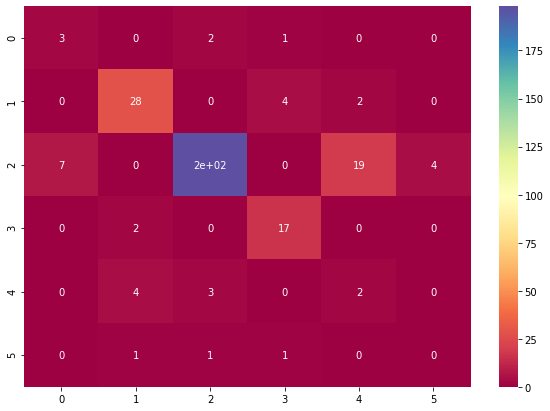

In [30]:
# A potential useful way to visualize the model results
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def matrix_plot(preds, y_test, variation): 

    confusion_matrix = np.zeros((6,6))

    for i,j in zip(preds,y_test):
    
            if abs(i-j) <= variation:
                confusion_matrix[i-1,i-1]+=1
            else: 
                confusion_matrix[i-1,j-1]+=1

    df_cm = confusion_matrix
    plt.figure(figsize=(10,7))
    sn.heatmap(df_cm, annot=True, cmap="Spectral") 
    plt.show()
    
matrix_plot(list(preds), list(y_test), 1)